In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-14 10:49:47.169560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 10:49:48.002406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 192
dataset_take = 7500
learning_rate = 9e-4
batch_per_file_size = 8
node_embedding_size = 15
layers = [128, 56, 28, 32, 24]

dataset = LayoutDataset(
    batch_size, dataset_take,
    build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-14 10:49:50.664601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 10:49:50.773511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 10:49:50.773750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 7500 False
train layout:nlp:random 7500 False
train layout:xla:random 7500 True
train layout:xla:default 7500 True
test all_filenames 10000 False
valid all_filenames 1000 False


In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    n_siblings=dataset.n_siblings,
    l1_multiplier=2e-8,
    output_name='layout_11_14_12_00'
)

In [4]:
mlp.train(dataset, None)

2023-11-14 10:54:18.713502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 10:54:18.815490: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f071a3c8560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 10:54:18.815577: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-14 10:54:18.863750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 10:54:19.135173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 10:54:19.364123: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.210545 lr 0.00004
iteration 1000 training loss 2.6400993 lr 0.00009
iteration 1500 training loss 2.717603 lr 0.00013
iteration 2000 training loss 2.3477838 lr 0.00018
iteration 2500 training loss 1.8727186 lr 0.00022
iteration 3000 training loss 2.2226489 lr 0.00027
iteration 3500 training loss 2.2866414 lr 0.00031
iteration 4000 training loss 2.2501013 lr 0.00036
iteration 4500 training loss 2.4062374 lr 0.00040
iteration 5000 training loss 2.1604042 lr 0.00045
iteration 5500 training loss 1.837859 lr 0.00049
iteration 6000 training loss 1.9791623 lr 0.00054
iteration 6500 training loss 2.1367285 lr 0.00058
iteration 7000 training loss 1.9142576 lr 0.00063
iteration 7500 training loss 1.8194134 lr 0.00067
iteration 8000 training loss 1.911568 lr 0.00072
iteration 8500 training loss 2.1815407 lr 0.00076
iteration 9000 training loss 1.746039 lr 0.00081
iteration 9500 training loss 1.3050102 lr 0.00085
iteration 10000 training loss 2.027978 lr 0.00090
layout

iteration 70000 training loss 0.9274002 lr 0.00078
layout:nlp:random 0.9196624471164327
layout:nlp:default 0.48141823013078405
layout:xla:random 0.6509612245681211
layout:xla:default 0.34917101792590827
epoch 0, it 70000 validation loss -0.600
iteration 70500 training loss 1.063392 lr 0.00078
iteration 71000 training loss 1.3236078 lr 0.00078
iteration 71500 training loss 1.1590343 lr 0.00078
iteration 72000 training loss 1.0020609 lr 0.00078
iteration 72500 training loss 1.3139195 lr 0.00077
iteration 73000 training loss 1.1211123 lr 0.00077
iteration 73500 training loss 0.8947903 lr 0.00077
iteration 74000 training loss 1.2129449 lr 0.00077
iteration 74500 training loss 1.1601337 lr 0.00077
iteration 75000 training loss 1.0331602 lr 0.00077
iteration 75500 training loss 1.1091763 lr 0.00076
iteration 76000 training loss 1.1777674 lr 0.00076
iteration 76500 training loss 1.2008833 lr 0.00076
iteration 77000 training loss 1.38334 lr 0.00076
iteration 77500 training loss 1.3434716 lr 0.

In [5]:
mlp.best_val_subsets

{'layout:nlp:random': 0.9220672319709682,
 'layout:nlp:default': 0.4875820405352048,
 'layout:xla:random': 0.6718509710875891,
 'layout:xla:default': 0.3732132444847759}

In [6]:
np.mean(list(mlp.best_val_subsets.values()))

0.6136783720196345

## Evaluate validation set

In [7]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

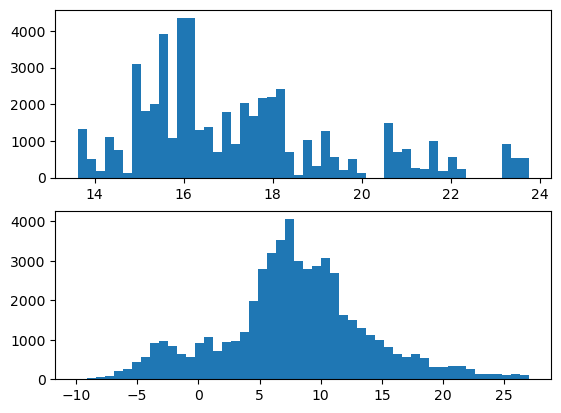

In [8]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [9]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:random:bert_multi_cased_L-12_H-76...,54,-9.845643,17.404863
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,24,-9.664339,17.055071
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,7,-9.225237,18.142097
b'layout:nlp:random:albert_en_xlarge_batch_size_16_test',b'layout:nlp:random:albert_en_xlarge_batch_siz...,52,-8.985600,17.862764
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:random:small_bert_bert_en_uncased...,8,-8.429619,17.015936
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,82,-7.688500,16.527267
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:default:tf2_bert_pretrain_dynamic...,25,-7.445944,17.943745
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,56,-7.136931,15.868072
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,159,-6.933022,15.195807


Text(0.5, 1.0, "b'layout:xla:random:bert_pretraining.4x4.fp16'")

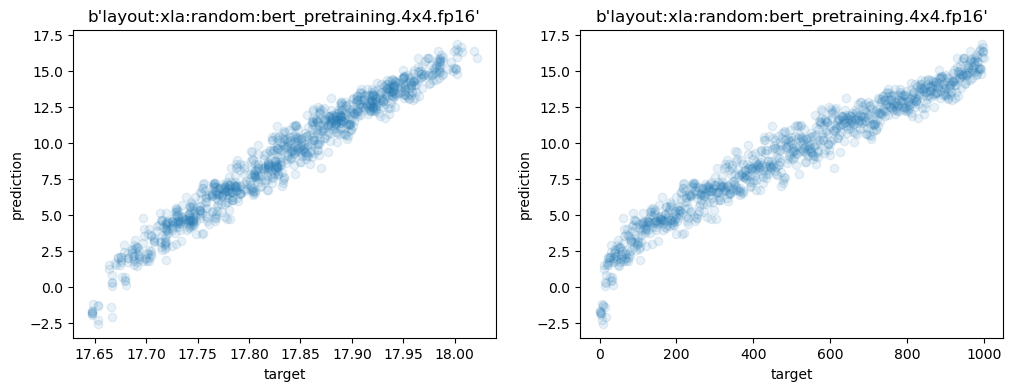

In [17]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

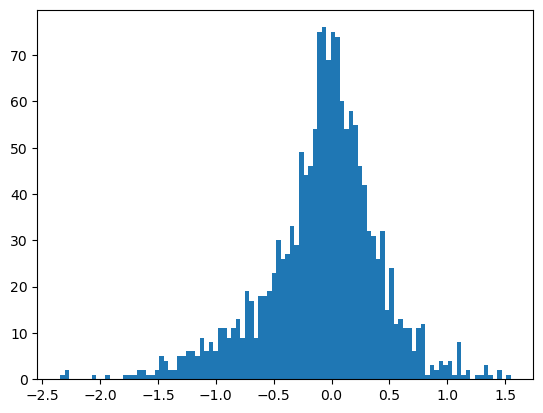

In [23]:
plt.hist(mlp.dense_layer_node_3.kernel.numpy().flatten(), bins=100);

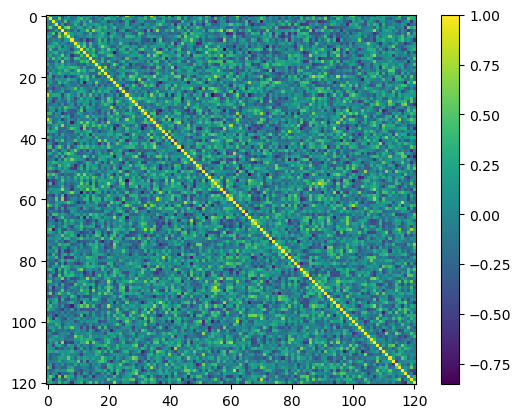

In [12]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [31]:
ind = np.unravel_index(np.argsort(dots.flatten())[-130], dots.shape)
ind

(20, 95)

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [32]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [33]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               17029;28042;17203;28057;52239;44362;26353;4436...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  31984;48680;51632;1633;65368;91629;31983;76672...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              15087;14731;22782;16975;22842;7933;11730;12955...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      30461;24051;54976;30275;89595;45619;22187;4953...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     9687;8460;9077;51640;29863;13434;7479;25212;13...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      24008;68506;25778;25794;21071;91552;25797;4253...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     328;449;11625;6637;471;180;1065;1009;412;517;3...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [34]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,23257,14.265278,16.145426
1,b'layout:nlp:default:small_bert_bert_en_uncase...,99694,11.560619,13.667519
2,b'layout:xla:random:unet_3d.4x4.bf16',0,3.852987,20.629971
3,b'layout:nlp:random:small_bert_bert_en_uncased...,98775,2.054575,16.050467
4,b'layout:nlp:default:small_bert_bert_en_uncase...,54409,7.480988,15.302357
...,...,...,...,...
53476,b'layout:nlp:random:bert_en_cased_L-12_H-768_A...,8911,2.369812,15.561594
53477,b'layout:nlp:default:bert_en_cased_L-12_H-768_...,86734,14.767642,15.561707
53478,b'layout:nlp:random:small_bert_bert_en_uncased...,5975,25.000397,18.496569
53479,b'layout:nlp:random:small_bert_bert_en_uncased...,6236,-1.859437,15.355140


In [35]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:xla:random', 'layout:nlp:random',
       'layout:xla:default'], dtype=object)

In [36]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
all_means = []
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    all_means.append(mean)
    print(subset, mean)
print(np.mean(all_means))

layout:nlp:default 0.4875820405352048
layout:xla:random 0.6683007220622873
layout:nlp:random 0.9218935097497505
layout:xla:default 0.31971310011740883
0.5993723431161628


In [ ]:
np.mean([
    0.9235,
    0.6591,
    0.516,
    0.358,
    0.968
])

In [37]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                 -0.001754
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.189277
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.267915
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.306957
b'layout:xla:default:inception_v3_batch_128_train'                                      0.338101
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.372886
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.394790
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.400143
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.412039
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.412772
b'layout:xla:default:bert_p

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:xla:random'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [38]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,0,9.470989
1,b'layout:nlp:random:58cc2e418c3a8a19b871e15964...,0,9.227304
2,b'layout:nlp:default:58cc2e418c3a8a19b871e1596...,0,8.917210
3,b'layout:xla:random:fbaa8bb6a1aed9988281085c91...,0,12.675463
4,b'layout:xla:random:5335ed13823b0a518ee3c79ba4...,0,15.230702
...,...,...,...
49997,b'layout:xla:default:3e7156ac468dfb75cf5c9615e...,999,-6.546533
49998,b'layout:nlp:random:492c7a94d559aa4a88769142d2...,999,21.295843
49999,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,999,16.429659
50000,b'layout:nlp:default:3a0c5517a87df8d82fd637b83...,1000,-4.878862


In [39]:
test_df.groupby('ID').count()

,config_index,prediction
ID,,
b'layout:nlp:default:016ac66a44a906a695afd2228509046a',1000,1000
b'layout:nlp:default:171b0513d8874a427ccfa46d136fbadc',1000,1000
b'layout:nlp:default:23559853d9702baaaacbb0c83fd32266',1000,1000
b'layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9',1000,1000
b'layout:nlp:default:32531d07a084b319dce484f53a4cf3fc',1000,1000
b'layout:nlp:default:38524e2ff135ded55b5286407e7af6b7',1000,1000
b'layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba',1001,1001
b'layout:nlp:default:492c7a94d559aa4a88769142d2a68362',1000,1000
b'layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad',1000,1000


In [40]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    750;923;360;15;487;314;174;466;28;541;558;579;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    784;741;490;273;513;896;837;731;559;15;321;298...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    616;377;840;17;526;941;320;807;543;46;148;705;...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    677;194;320;196;797;191;32;61;689;130;240;531;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    638;434;506;699;85;313;946;162;643;362;807;678...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    205;82;569;498;956;856;126;127;774;930;731;870...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    580;692;96;109;129;461;649;125;603;85;180;101;...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    675;118;472;697;908;683;631;12;778;4;861;656;6...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    180;166;570;339;404;675;265;879;919;402;584;51...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [41]:
test_prediction = pd.DataFrame(test_prediction, columns=['TopConfigs']).reset_index()
test_prediction

,ID,TopConfigs
0,layout:nlp:default:016ac66a44a906a695afd222850...,750;923;360;15;487;314;174;466;28;541;558;579;...
1,layout:nlp:default:171b0513d8874a427ccfa46d136...,784;741;490;273;513;896;837;731;559;15;321;298...
2,layout:nlp:default:23559853d9702baaaacbb0c83fd...,616;377;840;17;526;941;320;807;543;46;148;705;...
3,layout:nlp:default:29886a50d55cfe77a9497bc906c...,677;194;320;196;797;191;32;61;689;130;240;531;...
4,layout:nlp:default:32531d07a084b319dce484f53a4...,638;434;506;699;85;313;946;162;643;362;807;678...
5,layout:nlp:default:38524e2ff135ded55b5286407e7...,205;82;569;498;956;856;126;127;774;930;731;870...
6,layout:nlp:default:3a0c5517a87df8d82fd637b8329...,580;692;96;109;129;461;649;125;603;85;180;101;...
7,layout:nlp:default:492c7a94d559aa4a88769142d2a...,675;118;472;697;908;683;631;12;778;4;861;656;6...
8,layout:nlp:default:58cc2e418c3a8a19b871e15964b...,180;166;570;339;404;675;265;879;919;402;584;51...
9,layout:nlp:default:60880ed76de53f4d7a1b960b24f...,486;461;86;205;585;580;790;786;90;691;753;904;...


In [42]:
test_prediction['subset'] = test_prediction['ID'].apply(lambda x:':'.join(x.split(':')[:3]))

In [43]:
subset = 'layout:xla:default'
test_prediction[test_prediction['subset'] == subset]

,ID,TopConfigs,subset
34,layout:xla:default:05ae41e26dd3c4c06390371a042...,894;97;993;274;966;934;143;524;779;232;329;598...,layout:xla:default
35,layout:xla:default:3e7156ac468dfb75cf5c9615e1e...,320;809;678;333;467;921;256;671;96;855;234;948...,layout:xla:default
36,layout:xla:default:5335ed13823b0a518ee3c79ba44...,789;320;324;552;22;481;309;457;99;935;859;630;...,layout:xla:default
37,layout:xla:default:937ee0eb0d5d6151b7b8252933b...,38;937;629;211;448;256;733;93;184;307;729;982;...,layout:xla:default
38,layout:xla:default:cd708819d3f5103afd6460b15e7...,55;526;394;769;894;600;311;286;486;132;101;273...,layout:xla:default
39,layout:xla:default:db59a991b7c607634f13570d52c...,948;567;991;282;641;148;425;32;284;634;527;225...,layout:xla:default
40,layout:xla:default:e8a3a1401b5e79f66d7037e424f...,49;177;429;607;826;604;878;335;277;217;719;373...,layout:xla:default
41,layout:xla:default:fbaa8bb6a1aed9988281085c910...,90;452;937;498;111;506;524;984;495;750;477;641...,layout:xla:default


In [44]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_final_test_prediction_11_14_12_00.csv')